In [2]:
!pip install backtesting yfinance pandas


import yfinance as yf
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG
from tqdm import tqdm
import itertools


  Using cached backtesting-0.6.4-py3-none-any.whl.metadata (7.0 kB)
Using cached backtesting-0.6.4-py3-none-any.whl (191 kB)


/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [3]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4051    0  4051    0     0   8135      0 --:--:-- --:--:-- --:--:--  8150
100  517k  100  517k    0     0   588k      0 --:--:-- --:--:-- --:--:-- 1936k
--2025-04-23 19:15:21--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.144.37, 104.19.145.37, 2606:4700::6813:9025, ...
Connecting to anaconda.org (anaconda.org)|104.19.144.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

In [4]:
# Загрузка и подготовка данных
def load_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    ##data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp']]
    ##data.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp']
    #data.index = pd.to_datetime(data.index)  # Конвертируем индекс в datetime
    df.index = pd.to_datetime(df.index)
    df.columns = [df.columns[x][0] for x in range(len(df.columns))]
    #df.columns = df.columns.str.lower()
    df['date'] = df.index
    return df


In [5]:
class SmaCross(Strategy):
    n1 = 40
    n2 = 200
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, self.n1)
        self.ma2 = self.I(SMA, price, self.n2)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()



In [6]:
class RobustRsiStrategy(Strategy):
    rsi_period = 14
    rsi_overbought = 80
    rsi_oversold = 20

    def init(self):
        # Преобразуем данные в numpy array с проверкой
        close_prices = np.asarray(self.data.Close)
        if len(close_prices) < self.rsi_period + 1:
            raise ValueError(f"Недостаточно данных для RSI периода {self.rsi_period}")

        # Вычисляем RSI с защитой от ошибок
        delta = np.diff(close_prices)
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)

        # Вычисляем скользящие средние с минимальным периодом
        avg_gain = np.full_like(gain, np.nan)
        avg_loss = np.full_like(loss, np.nan)

        for i in range(self.rsi_period, len(gain)):
            avg_gain[i] = np.mean(gain[i-self.rsi_period:i])
            avg_loss[i] = np.mean(loss[i-self.rsi_period:i])

        # Вычисляем RSI с защитой от деления на ноль
        with np.errstate(divide='ignore', invalid='ignore'):
            rs = np.where(avg_loss != 0, avg_gain / avg_loss, np.inf)
            rsi = 100 - (100 / (1 + rs))

        # Сохраняем RSI, добавляя NaN в начало
        self.rsi_line = np.concatenate(([np.nan], rsi))

    def next(self):
        if len(self.rsi_line) < 2 or np.isnan(self.rsi_line[-1]):
            return

        current_rsi = self.rsi_line[-1]

        if not self.position and current_rsi < self.rsi_oversold:
            if not np.isnan(current_rsi):
                self.buy()

        elif self.position and current_rsi > self.rsi_overbought:
            if not np.isnan(current_rsi):
                self.position.close()


In [7]:
class ImprovedRsiStrategy(Strategy):
    rsi_period = 14
    rsi_overbought = 70
    rsi_oversold = 30
    ma_period = 200

    def init(self):
        close = self.data.Close

        # RSI расчет
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(self.rsi_period).mean()
        avg_loss = loss.rolling(self.rsi_period).mean()
        rs = avg_gain / avg_loss
        self.rsi = 100 - (100 / (1 + rs))

        # Скользящая средняя для трендового фильтра
        self.ma = close.rolling(self.ma_period).mean()

    def next(self):
        price = self.data.Close[-1]

        # Покупаем только если цена выше MA (восходящий тренд)
        if (not self.position and
            self.rsi[-1] < self.rsi_oversold and
            price > self.ma[-1]):
            self.buy()

        # Продаем только если цена ниже MA (нисходящий тренд)
        elif (self.position and
              (self.rsi[-1] > self.rsi_overbought or
               price < self.ma[-1])):
            self.position.close()

In [8]:
class MACDStrategy(Strategy):
    # Параметры стратегии
    fast_period = 12
    slow_period = 26
    signal_period = 9

    def init(self):
        # Рассчитываем MACD и Signal line
        close = self.data.Close
        self.macd, self.signal, _ = self.I(
            talib.MACD, close,
            fastperiod=self.fast_period,
            slowperiod=self.slow_period,
            signalperiod=self.signal_period
        )

    def next(self):
        # Если нет позиции и MACD пересекает Signal снизу вверх - покупаем
        if not self.position and crossover(self.macd, self.signal):
            self.buy()

        # Если есть позиция и MACD пересекает Signal сверху вниз - продаем
        elif self.position and crossover(self.signal, self.macd):
            self.position.close()


In [21]:
TICKER = 'AAPL'
START_DATE = '2010-01-01'
END_DATE = '2023-01-01'
COMMISSION = 0.002

data = load_data(TICKER, START_DATE, END_DATE)

# Разделение данных
split = int(len(data) * 0.6)
# обучающая
train_data = data.iloc[:split]
rest_data = data.iloc[split:]


split = int(len(rest_data) * 0.5)
# тестовая
test_data = rest_data.iloc[:split]

# валидационная
val_data = rest_data.iloc[split:]



[*********************100%***********************]  1 of 1 completed


In [22]:
def get_best_sma_strategy(buffer):

    n1=[10, 15, 20, 25]
    n2=[20, 25, 30, 35]
    best_params = None
    best_performance = -float('inf')

    bt = Backtest(buffer.copy(), SmaCross, commission=COMMISSION)

    # Проходим по всем комбинациям параметров
    for n1_val, n2_val in itertools.product(n1, n2):
        if n1_val >= n2_val:
          continue

        stats = bt.run(n1=n1_val, n2=n2_val)

        # Определяем метрику, по которой будем выбирать лучшую стратегию
        performance = stats['Equity Final [$]']

        # Сравниваем с лучшим результатом и сохраняем лучшие параметры
        if performance > best_performance:
            best_performance = performance
            best_params = {'n1': n1_val, 'n2': n2_val}

    print(f"Best Performance: {best_performance}")
    print(f"Best Parameters: {best_params}")
    return best_params

sma_bp = get_best_sma_strategy(train_data)


Backtest.run:   0%|          | 0/1943 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=90: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=106: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=128: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=142: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=156: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=172: B

Backtest.run:   0%|          | 0/1938 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=92: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=107: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=128: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=145: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=157: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=174: B

Backtest.run:   0%|          | 0/1933 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=94: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=108: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=129: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=146: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=157: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=174: B

Backtest.run:   0%|          | 0/1928 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=96: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=111: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=130: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=147: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=158: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=175: B

Backtest.run:   0%|          | 0/1943 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=93: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=103: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=106: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=111: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=131: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=141: B

Backtest.run:   0%|          | 0/1938 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=95: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=111: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=132: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=146: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=159: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=176: B

Backtest.run:   0%|          | 0/1933 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=96: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=112: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=132: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=149: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=160: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=177: B

Backtest.run:   0%|          | 0/1928 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=98: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=114: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=133: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=151: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=161: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=177: B

Backtest.run:   0%|          | 0/1938 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=97: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=107: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=111: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=115: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=126: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=127: B

Backtest.run:   0%|          | 0/1933 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=98: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=115: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=137: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=150: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=162: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=179: B

Backtest.run:   0%|          | 0/1928 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=100: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=116: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=136: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=154: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=162: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=180: 

Backtest.run:   0%|          | 0/1933 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=102: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=113: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=117: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=119: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=130: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=132: 

Backtest.run:   0%|          | 0/1928 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=103: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=117: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=142: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=155: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=166: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=181: 

Best Performance: 62846.40452737484
Best Parameters: {'n1': 10, 'n2': 25}


In [23]:
bt = Backtest(test_data.copy(), SmaCross, commission=COMMISSION)
state = bt.run(**sma_bp)
print(state)
bt.plot()


Backtest.run:   0%|          | 0/629 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=43: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=56: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=57: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=87: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=107: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=123: Brok

Start                     2017-10-19 00:00:00
End                       2020-05-27 00:00:00
Duration                    951 days 00:00:00
Exposure Time [%]                    43.57798
Equity Final [$]                   1135.89837
Equity Peak [$]                   11479.72631
Commissions [$]                       3.69024
Return [%]                          -88.64102
Buy & Hold Return [%]                88.27405
Return (Ann.) [%]                   -56.74838
Volatility (Ann.) [%]                112.6509
CAGR [%]                            -43.80731
Sharpe Ratio                         -0.50375
Sortino Ratio                        -0.67952
Calmar Ratio                         -0.60236
Alpha [%]                           167.97798
Beta                                 -2.90707
Max. Drawdown [%]                   -94.21053
Avg. Drawdown [%]                   -25.93771
Max. Drawdown Duration      510 days 00:00:00
Avg. Drawdown Duration      150 days 00:00:00
# Trades                          

GridPlot(id='p2147', ...)

In [25]:
def get_best_macd_strategy(buffer):
    fast_period = [8, 24, 4]
    slow_period = [23, 39, 3]
    signal_period = [3, 6, 9, 12]

    best_params = None
    best_performance = -float('inf')
    trade = 0

    bt = Backtest(buffer.copy(), MACDStrategy, commission=COMMISSION)

    # Проходим по всем комбинациям параметров
    for fast_period_val, slow_period_val, signal_period_val in itertools.product(fast_period, slow_period, signal_period):
        if fast_period_val >= slow_period_val:
          continue

        stats = bt.run()

        # Определяем метрику, по которой будем выбирать лучшую стратегию
        performance = stats['Equity Final [$]']

        # Сравниваем с лучшим результатом и сохраняем лучшие параметры
        if performance > best_performance:
            best_performance = performance
            trade = len(stats._trades)
            best_params = {'fast_period': fast_period_val, 'slow_period': slow_period_val, 'signal_period': signal_period_val}

    print(f"Best Performance: {best_performance}")
    print(f"Best Parameters: {best_params}")
    print(f"Trades: {trade}")
    return best_params

macd_bp = get_best_macd_strategy(train_data)


Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1929 [00:00<?, ?bar/s]

Best Performance: 20792.897809784157
Best Parameters: {'fast_period': 8, 'slow_period': 23, 'signal_period': 3}
Trades: 72


In [27]:
bt = Backtest(test_data.copy(), MACDStrategy, commission=COMMISSION)
state = bt.run(**macd_bp)
print(state)
bt.plot()


Backtest.run:   0%|          | 0/629 [00:00<?, ?bar/s]

Start                     2017-10-19 00:00:00
End                       2020-05-27 00:00:00
Duration                    951 days 00:00:00
Exposure Time [%]                     55.8104
Equity Final [$]                  12686.03525
Equity Peak [$]                   13856.16163
Commissions [$]                    2173.64304
Return [%]                           26.86035
Buy & Hold Return [%]                88.27405
Return (Ann.) [%]                     9.60078
Volatility (Ann.) [%]                22.69669
CAGR [%]                              6.50739
Sharpe Ratio                            0.423
Sortino Ratio                          0.6539
Calmar Ratio                          0.29297
Alpha [%]                            -6.35783
Beta                                  0.37631
Max. Drawdown [%]                   -32.77009
Avg. Drawdown [%]                    -4.73828
Max. Drawdown Duration      475 days 00:00:00
Avg. Drawdown Duration       54 days 00:00:00
# Trades                          

GridPlot(id='p2570', ...)

In [28]:
bt = Backtest(test_data.copy(), MACDStrategy, commission=COMMISSION)
macd_state = bt.run(**macd_bp)

bt = Backtest(test_data.copy(), SmaCross, commission=COMMISSION)
sma_state = bt.run(**sma_bp)


Backtest.run:   0%|          | 0/629 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/629 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=43: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=56: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=57: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=87: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=107: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:954: UserWarning: time=123: Brok

,Параметры,Equity Final,Sharpe Ratio,Max Drawdown
SMA_Crossover,"{'n1': 10, 'n2': 25}",1135.90$,-0.503754,-9421.1%
MACD,"{'fast_period': 8, 'slow_period': 23, 'signal_period': 3}",12686.04$,0.423004,-3277.0%


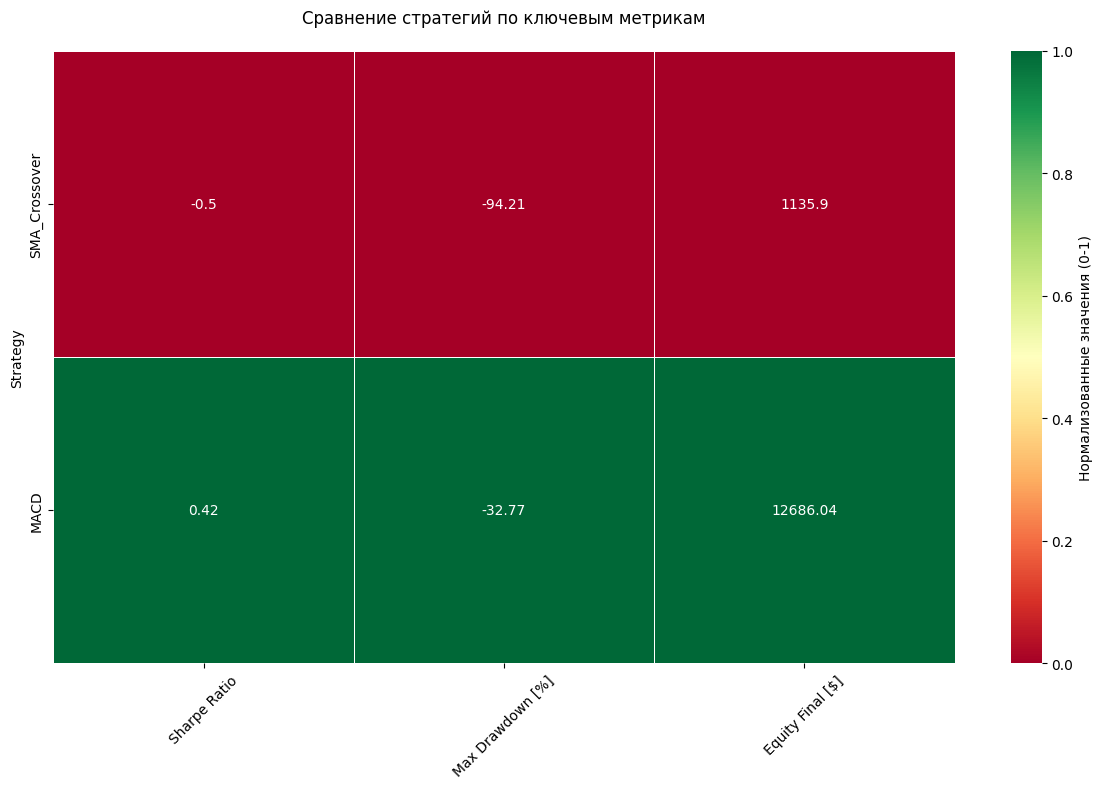

In [37]:
# Дашборды

import matplotlib.pyplot as plt
import seaborn as sns

strategies = {
    'SMA_Crossover': {
        'params': sma_bp,
        'equity': sma_state["Equity Final [$]"],
        'sharpe': sma_state["Sharpe Ratio"],
        'max_drawdown': sma_state["Max. Drawdown [%]"]
    },
    'MACD': {
        'params': macd_bp,
        'equity': macd_state["Equity Final [$]"],
        'sharpe': macd_state["Sharpe Ratio"],
        'max_drawdown': macd_state["Max. Drawdown [%]"]
    },
}

# Сводная таблица результатов
results_df = pd.DataFrame({
    name: [
        str(params['params']),
        f"{params['equity']:.2f}$",
        params['sharpe'],
        f"{params['max_drawdown']*100:.1f}%"
    ]
    for name, params in strategies.items()
}).T
results_df.columns = ['Параметры', 'Equity Final', 'Sharpe Ratio', 'Max Drawdown']
display(results_df.style.background_gradient(cmap='RdYlGn'))

# Heatmap сравнения метрик
metrics_data = []
for strategy_name, strategy_data in strategies.items():
    metrics_data.append({
        'Strategy': strategy_name,
        'Sharpe Ratio': strategy_data['sharpe'],
        'Max Drawdown [%]': strategy_data['max_drawdown'],
        'Equity Final [$]': strategy_data['equity'],
        'Parameters': str(strategy_data['params'])
    })

metrics_df = pd.DataFrame(metrics_data).set_index('Strategy')

heatmap_df = metrics_df.drop(columns=['Parameters'])
heatmap_df_normalized = (heatmap_df - heatmap_df.min()) / (heatmap_df.max() - heatmap_df.min())

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_df_normalized,
    annot=heatmap_df.round(2),
    fmt='',
    cmap='RdYlGn',
    center=0.5,
    linewidths=.5,
    cbar_kws={'label': 'Нормализованные значения (0-1)'}
)

plt.title('Сравнение стратегий по ключевым метрикам', pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
